# Face Mask Detection using NVIDIA TLT 

The MIT License (MIT)

Copyright (c) 2019-2020, NVIDIA CORPORATION.

Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the "Software"), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
the Software, and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## DetectNet_v2 with ResNet-18 example usecase

The goal of this notebook is to utilize NVIDIA TLT to train and make Face Mask detection model deploy ready.
While working on such application, this notebook will serve as an example usecase of Object Detection using DetectNet_v2 in the Transfer Learning Toolkit.

0. [Set up env variables](#head-0)
1. [Prepare dataset and pre-trained model](#head-1)
    1. [Download dataset and convert in KITTI Format](#head-1-1)
    1. [Prepare tfrecords from kitti format dataset](#head-1-2)
    2. [Download pre-trained model](#head-1-3)
2. [Provide training specification](#head-2)
3. [Run TLT training](#head-3)
4. [Evaluate trained models](#head-4)
5. [Prune trained models](#head-5)
6. [Retrain pruned models](#head-6)
7. [Evaluate retrained model](#head-7)
8. [Visualize inferences](#head-8)
9. [Deploy](#head-9)
    1. [Int8 Optimization](#head-9-1)
    2. [Generate TensorRT engine](#head-9-2)
10. [Verify Deployed Model](#head-10)
    1. [Inference using TensorRT engine](#head-10-1)

![Face Mask Detection Output](https://github.com/NVIDIA-AI-IOT/face-mask-detection/blob/master/images/face-mask-detect-output.png)

## 0. Set up env variables <a class="anchor" id="head-0"></a>
When using the purpose-built pretrained models from NGC, please make sure to set the `$KEY` environment variable to the key as mentioned in the model overview. Failing to do so, can lead to errors when trying to load them as pretrained models.

*Note: Please make sure to remove any stray artifacts/files from the `$USER_EXPERIMENT_DIR` or `$DATA_DOWNLOAD_DIR` paths as mentioned below, that may have been generated from previous experiments. Having checkpoint files etc may interfere with creating a training graph for a new experiment.*

In [2]:
!sudo rm -r /workspace/data  


In [3]:
!sudo rm -r /workspace/detectnet_v2 

In [4]:
# Setting up env variables for cleaner command line commands.
%env KEY= 
%env USER_EXPERIMENT_DIR=/workspace/detectnet_v2 
%env DATA_DOWNLOAD_DIR=/workspace/data           
%env SPECS_DIR=/workspace/tlt_specs/    

env: KEY=tlt_encode
env: USER_EXPERIMENT_DIR=/workspace/detectnet_v2
env: DATA_DOWNLOAD_DIR=/workspace/data
env: SPECS_DIR=/workspace/tlt_specs/


## 1. Prepare dataset and pre-trained model <a class="anchor" id="head-1"></a>

### A. Download dataset and convert in KITTI Format <a class="anchor" id="head-1-1"></a>

In this experiment we will be using 4 different datasets; 

1. Faces with Mask:
    - Kaggle Medical Mask Dataset [Download Link](https://www.kaggle.com/vtech6/medical-masks-dataset)
    - MAFA - MAsked FAces [Download Link](http://www.escience.cn/people/geshiming/mafa.html)
2. Faces without Mask:
    - FDDB Dataset [Download Link](http://vis-www.cs.umass.edu/fddb/)
    - WiderFace Dataset [Download Link](http://shuoyang1213.me/WIDERFACE/)

- Download the data using provided links, such that all images and label files are in one folder. We expect in structure noted in GitHub repo.
- Convert dataset to KITTI format 
- Use KITTI format directory as "$DATA_DOWNLOAD_DIR"


Note: We do not use all the images from MAFA and WiderFace. Combining we will use about 6000 faces each with and without mask

### B. Prepare tf records from kitti format dataset <a class="anchor" id="head-1-2"></a>

* Update the tfrecords spec file to take in your kitti format dataset
* Create the tfrecords using the tlt-dataset-convert 

*Note: TfRecords only need to be generated once.*

In [5]:
print("TFrecords conversion spec file for kitti training")
!cat $SPECS_DIR/detectnet_v2_tfrecords_kitti_train.txt

TFrecords conversion spec file for kitti training
kitti_config {
  root_directory_path: "/workspace/data_train/train"
  image_dir_name: "images"
  label_dir_name: "labels"
  image_extension: ".jpg"
  partition_mode: "random"
  num_partitions: 2
  val_split: 20
  num_shards: 10 }


In [6]:
!sudo ls /workspace/data_train/train

images	labels


In [7]:
# Creating a new directory for the output tfrecords dump.
print("Converting Tfrecords for kitti trainval dataset")
!tlt-dataset-convert -d $SPECS_DIR/detectnet_v2_tfrecords_kitti_train.txt \
                     -o $DATA_DOWNLOAD_DIR/tfrecords/kitti_trainval/kitti_trainval

Converting Tfrecords for kitti trainval dataset
2020-10-07 08:36:54.687540: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
Using TensorFlow backend.
2020-10-07 08:37:41,414 - iva.detectnet_v2.dataio.build_converter - INFO - Instantiating a kitti converter
2020-10-07 08:37:41,415 - iva.detectnet_v2.dataio.dataset_converter_lib - INFO - Creating output directory /workspace/data/tfrecords/kitti_trainval
2020-10-07 08:37:41,516 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Num images in
Train: 2508	Val: 626
2020-10-07 08:37:41,516 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Validation data in partition 0. Hence, while choosing the validationset during training choose validation_fold 0.
2020-10-07 08:37:41,520 - iva.detectnet_v2.dataio.dataset_converter_lib - INFO - Writing partition 0, shard 0

2020-10-07 08:37:41,520 - tensorflow - WARNING - From /home/vpraveen/.cache/dazel/_dazel_vpraveen/715c8bafe

Top left coordinate must be less than bottom right.Error in object 0 of label_file /workspace/data_train/train/labels/154_mask.txt. 
Coordinates: x1 = 766, x2 = 573, y1: 84, y2: 323
Skipping this object
Top left coordinate must be less than bottom right.Error in object 0 of label_file /workspace/data_train/train/labels/403_mask.txt. 
Coordinates: x1 = 667, x2 = 506, y1: 181, y2: 341
Skipping this object
2020-10-07 08:38:08,104 - iva.detectnet_v2.dataio.dataset_converter_lib - INFO - Writing partition 1, shard 1
Top left coordinate must be less than bottom right.Error in object 0 of label_file /workspace/data_train/train/labels/493_mask.txt. 
Coordinates: x1 = 725, x2 = 385, y1: 71, y2: 371
Skipping this object
Top left coordinate must be less than bottom right.Error in object 0 of label_file /workspace/data_train/train/labels/train_00000650.txt. 
Coordinates: x1 = 412, x2 = 50, y1: 133, y2: 509
Skipping this object
Top left coordinate must be less than bottom right.Error in object 0 of

2020-10-07 08:38:40,041 - iva.detectnet_v2.dataio.dataset_converter_lib - INFO - Writing partition 1, shard 5
Top left coordinate must be less than bottom right.Error in object 0 of label_file /workspace/data_train/train/labels/113_mask.txt. 
Coordinates: x1 = 535, x2 = 384, y1: 164, y2: 355
Skipping this object
Top left coordinate must be less than bottom right.Error in object 0 of label_file /workspace/data_train/train/labels/469_mask.txt. 
Coordinates: x1 = 732, x2 = 226, y1: 116, y2: 504
Skipping this object
Top left coordinate must be less than bottom right.Error in object 0 of label_file /workspace/data_train/train/labels/68_mask.txt. 
Coordinates: x1 = 848, x2 = 783, y1: 78, y2: 155
Skipping this object
Top left coordinate must be less than bottom right.Error in object 1 of label_file /workspace/data_train/train/labels/68_mask.txt. 
Coordinates: x1 = 243, x2 = 159, y1: 85, y2: 178
Skipping this object
Top left coordinate must be less than bottom right.Error in object 2 of label_

In [9]:
!ls -rlt $DATA_DOWNLOAD_DIR/tfrecords/kitti_trainval/

total 2196
-rw-r--r-- 1 root root  43728 Oct  7 08:37 kitti_trainval-fold-000-of-002-shard-00000-of-00010
-rw-r--r-- 1 root root  42517 Oct  7 08:37 kitti_trainval-fold-000-of-002-shard-00001-of-00010
-rw-r--r-- 1 root root  42045 Oct  7 08:37 kitti_trainval-fold-000-of-002-shard-00002-of-00010
-rw-r--r-- 1 root root  43979 Oct  7 08:37 kitti_trainval-fold-000-of-002-shard-00003-of-00010
-rw-r--r-- 1 root root  44187 Oct  7 08:37 kitti_trainval-fold-000-of-002-shard-00004-of-00010
-rw-r--r-- 1 root root  42276 Oct  7 08:37 kitti_trainval-fold-000-of-002-shard-00005-of-00010
-rw-r--r-- 1 root root  44788 Oct  7 08:37 kitti_trainval-fold-000-of-002-shard-00006-of-00010
-rw-r--r-- 1 root root  43687 Oct  7 08:37 kitti_trainval-fold-000-of-002-shard-00007-of-00010
-rw-r--r-- 1 root root  40111 Oct  7 08:37 kitti_trainval-fold-000-of-002-shard-00008-of-00010
-rw-r--r-- 1 root root  45927 Oct  7 08:37 kitti_trainval-fold-000-of-002-shard-00009-of-00010
-rw-r--r-- 1 root root 172872 Oct  7 08

### C. Download pre-trained model <a class="anchor" id="head-1-3"></a>
Download the correct pretrained model from the NGC model registry for your experiment. Please note that for DetectNet_v2, the input is expected to be 0-1 normalized with input channels in RGB order. Therefore, for optimum results please download models with `*_detectnet_v2` in their name string. All other models expect input preprocessing with mean subtraction and input channels in BGR order. Thus, using them as pretrained weights may result in suboptimal performance. 

In [10]:
# List models available in the model registry.
!ngc registry model list nvidia/tlt_pretrained_detectnet_v2:*

+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| Versi | Accur | Epoch | Batch | GPU   | Memor | File  | Statu | Creat |
| on    | acy   | s     | Size  | Model | y Foo | Size  | s     | ed    |
|       |       |       |       |       | tprin |       |       | Date  |
|       |       |       |       |       | t     |       |       |       |
+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| resne | 79.5  | 80    | 1     | V100  | 163.6 | 163.5 | UPLOA | Aug   |
| t34   |       |       |       |       |       | 5 MB  | D_COM | 03,   |
|       |       |       |       |       |       |       | PLETE | 2020  |
| resne | 79.2  | 80    | 1     | V100  | 38.3  | 38.34 | UPLOA | Apr   |
| t10   |       |       |       |       |       | MB    | D_COM | 29,   |
|       |       |       |       |       |       |       | PLETE | 2020  |
| resne | 79.0  | 80    | 1     | V100  | 89.0  | 89.02 | UPLOA | Apr   |
| t18   |       |       |       |     

In [11]:
# Create the target destination to download the model.
!mkdir -p $USER_EXPERIMENT_DIR/pretrained_resnet18/

In [12]:
# Download the pretrained model from NGC
!ngc registry model download-version nvidia/tlt_pretrained_detectnet_v2:resnet18 \
    --dest $USER_EXPERIMENT_DIR/pretrained_resnet18

Downloaded 82.28 MB in 14s, Download speed: 5.87 MB/s               
----------------------------------------------------
Transfer id: tlt_pretrained_detectnet_v2_vresnet18 Download status: Completed.
Downloaded local path: /workspace/detectnet_v2/pretrained_resnet18/tlt_pretrained_detectnet_v2_vresnet18
Total files downloaded: 1 
Total downloaded size: 82.28 MB
Started at: 2020-10-07 08:40:50.859316
Completed at: 2020-10-07 08:41:04.881685
Duration taken: 14s
----------------------------------------------------


In [13]:
!ls -rlt $USER_EXPERIMENT_DIR/pretrained_resnet18/tlt_pretrained_detectnet_v2_vresnet18

total 91160
-rw------- 1 root root 93345248 Oct  7 08:41 resnet18.hdf5


## 2. Provide training specification <a class="anchor" id="head-2"></a>
* Tfrecords for the train datasets
    * In order to use the newly generated tfrecords, update the dataset_config parameter in the spec file at `$SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt` 
    * Update the fold number to use for evaluation. In case of random data split, please use fold `0` only
    * For sequence-wise split, you may use any fold generated from the dataset convert tool
* Pre-trained models
* Augmentation parameters for on the fly data augmentation
* Other training (hyper-)parameters such as batch size, number of epochs, learning rate etc.

In [14]:
!cat $SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt

random_seed: 42
dataset_config {
  data_sources {
    tfrecords_path: "/workspace/data/tfrecords/kitti_trainval/*"
    image_directory_path: "/workspace/data_train/train"
  }
  image_extension: "jpg"
  target_class_mapping {
    key: "mask"
    value: "mask"
  }
  target_class_mapping {
    key: "no-mask"
    value: "no-mask"
  }
  validation_fold: 0
  #validation_data_source: {
    #tfrecords_path: "/home/data/tfrecords/kitti_val/*"
    #image_directory_path: "/home/data/test"
  #}
}


augmentation_config {
  preprocessing {
    output_image_width: 960
    output_image_height: 544
    min_bbox_width: 1.0
    min_bbox_height: 1.0
    output_image_channel: 3
  }
  spatial_augmentation {
    hflip_probability: 0.5
    vflip_probability: 0.0
    zoom_min: 1.0
    zoom_max: 1.0
    translate_max_x: 8.0
    translate_max_y: 8.0
  }
  color_augmentation {
    hue_rotation_max: 25.0
    saturation_shift_max: 0.20000000298
    contrast_scale_max: 0.10000000149
    contrast_center: 0.5
  }
}

p

## 3. Run TLT training <a class="anchor" id="head-3"></a>
* Provide the sample spec file and the output directory location for models

*Note: The training may take hours to complete. Also, the remaining notebook, assumes that the training was done in single-GPU mode. When run in multi-GPU mode, please expect to update the pruning and inference steps with new pruning thresholds and updated parameters in the clusterfile.json accordingly for optimum performance.*

*Detectnet_v2 now supports restart from checkpoint. Incase, the training job is killed prematurely, you may resume training from the closest checkpoint by simply re-running the same command line. Please do make sure to use the same number of GPUs when restarting the training.*

In [15]:
!tlt-train detectnet_v2 -e $SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt \
                        -r $USER_EXPERIMENT_DIR/experiment_dir_unpruned \
                        -k $KEY \
                        -n resnet18_detector

Using TensorFlow backend.
2020-10-07 08:41:09.598522: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-10-07 08:41:25.106512: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-10-07 08:41:25.195853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-07 08:41:25.196279: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:01:00.0
2020-10-07 08:41:25.196309: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-10-07 08:41:25.196376: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully ope

2020-10-07 08:42:04,246 [INFO] iva.detectnet_v2.dataloader.default_dataloader: Bounding box coordinates were detected in the input specification! Bboxes will be automatically converted to polygon coordinates.
2020-10-07 08:42:04.410151: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-07 08:42:04.410707: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:01:00.0
2020-10-07 08:42:04.410753: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-10-07 08:42:04.410814: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-10-07 08:42:04.410856: I tensorflow/stream_executor/platform/

2020-10-07 08:43:11.726544: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.24GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2020-10-07 08:43:11.726644: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.24GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2020-10-07 08:43:11.751817: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc) ran out of memory trying to allocate 700.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2020-10-07 08:43:11.751847: W tensorflow/core/common_runtime/bfc_allocator.cc:239] All

2020-10-07 08:51:01,661 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 47.666
2020-10-07 08:51:12,563 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 45.864
2020-10-07 08:51:24,193 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 42.991
2020-10-07 08:51:35,848 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 42.904
2020-10-07 08:51:40,079 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 9/120: loss: 0.00151 Time taken: 0:00:55.658982 ETA: 1:42:58.146980
2020-10-07 08:51:46,430 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 47.249
2020-10-07 08:51:57,027 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 47.183
2020-10-07 08:52:07,572 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 47.419
2020-10-07 08:52:18,076 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 47.601
2020-10-07 08:52:28,536 [INFO] modulus.hooks.sample_counte

2020-10-07 09:04:09,487 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 47.945
2020-10-07 09:04:19,923 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 47.911
2020-10-07 09:04:31,717 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 42.396
2020-10-07 09:04:45,743 [INFO] iva.detectnet_v2.evaluation.evaluation: step 0 / 31, 0.00s/step
2020-10-07 09:04:57,554 [INFO] iva.detectnet_v2.evaluation.evaluation: step 10 / 31, 1.18s/step
2020-10-07 09:05:09,540 [INFO] iva.detectnet_v2.evaluation.evaluation: step 20 / 31, 1.20s/step
2020-10-07 09:05:22,023 [INFO] iva.detectnet_v2.evaluation.evaluation: step 30 / 31, 1.25s/step
Matching predictions to ground truth, class 2/2.: 100%|█| 5788/5788 [00:00<00:00, 18117.52it/s]
Epoch 20/120

Validation cost: 0.000364
Mean average_precision (in %): 44.2596

class name      average precision (in %)
------------  --------------------------
mask                             13.0231
no-mask                          75.

Matching predictions to ground truth, class 2/2.: 100%|█| 3142/3142 [00:00<00:00, 17474.04it/s]
Epoch 30/120

Validation cost: 0.000313
Mean average_precision (in %): 58.5558

class name      average precision (in %)
------------  --------------------------
mask                             40.385
no-mask                          76.7266

Median Inference Time: 0.007524
2020-10-07 09:14:44,386 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 30/120: loss: 0.00082 Time taken: 0:01:11.722414 ETA: 1:47:35.017219
2020-10-07 09:14:53,507 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 16.954
2020-10-07 09:15:05,505 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 41.675
2020-10-07 09:15:17,911 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 40.305
2020-10-07 09:15:30,040 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 41.224
2020-10-07 09:15:40,657 [INFO] modulus.hooks.sample_counter_h

2020-10-07 09:24:21,813 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 44.942
2020-10-07 09:24:33,572 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 42.523
2020-10-07 09:24:44,573 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 45.452
2020-10-07 09:24:55,469 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 45.888
2020-10-07 09:25:02,651 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 41/120: loss: 0.00076 Time taken: 0:00:56.031419 ETA: 1:13:46.482066
2020-10-07 09:25:06,010 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 47.434
2020-10-07 09:25:16,594 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 47.240
2020-10-07 09:25:27,379 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 46.362
2020-10-07 09:25:38,157 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 46.395
2020-10-07 09:25:48,932 [INFO] modulus.hooks.sample_count

2020-10-07 09:34:44,559 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 47.226
2020-10-07 09:34:55,102 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 47.425
2020-10-07 09:35:05,765 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 46.889
2020-10-07 09:35:16,500 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 46.579
2020-10-07 09:35:17,786 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 52/120: loss: 0.00065 Time taken: 0:00:53.554593 ETA: 1:00:41.712297
2020-10-07 09:35:27,185 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 46.793
2020-10-07 09:35:37,985 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 46.300
2020-10-07 09:35:48,720 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 46.575
2020-10-07 09:35:59,428 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 46.699
2020-10-07 09:36:10,141 [INFO] modulus.hooks.sample_count

2020-10-07 09:45:15,979 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 45.937
2020-10-07 09:45:27,248 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 44.370
2020-10-07 09:45:37,901 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 46.938
2020-10-07 09:45:43,961 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 63/120: loss: 0.00044 Time taken: 0:00:54.179466 ETA: 0:51:28.229590
2020-10-07 09:45:48,693 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 46.331
2020-10-07 09:46:00,687 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 41.690
2020-10-07 09:46:12,219 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 43.357
2020-10-07 09:46:23,744 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 43.385
2020-10-07 09:46:34,087 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 48.344
2020-10-07 09:46:40,456 [INFO] /usr/local/lib/python3.6/d

2020-10-07 09:55:45,237 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 46.492
2020-10-07 09:55:55,792 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 47.373
2020-10-07 09:56:06,470 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 74/120: loss: 0.00050 Time taken: 0:00:54.301973 ETA: 0:41:37.890763
2020-10-07 09:56:06,470 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 46.823
2020-10-07 09:56:17,177 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 46.700
2020-10-07 09:56:27,931 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 46.496
2020-10-07 09:56:38,608 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 46.829
2020-10-07 09:56:49,392 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 46.367
2020-10-07 09:57:00,152 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 46.470
2020-10-07 09:57:00,563 [INFO] /usr/local/lib/python3.6/d

2020-10-07 10:06:20,886 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 47.971
2020-10-07 10:06:31,830 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 45.688
2020-10-07 10:06:36,612 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 85/120: loss: 0.00042 Time taken: 0:00:55.678025 ETA: 0:32:28.730875
2020-10-07 10:06:43,109 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 44.331
2020-10-07 10:06:54,755 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 42.932
2020-10-07 10:07:06,428 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 42.834
2020-10-07 10:07:16,862 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 47.924
2020-10-07 10:07:27,493 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 47.030
2020-10-07 10:07:32,449 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 86/120: loss: 0.00043 Time ta

2020-10-07 10:16:56,748 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 49.352
2020-10-07 10:17:06,446 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 96/120: loss: 0.00031 Time taken: 0:00:56.433646 ETA: 0:22:34.407515
2020-10-07 10:17:07,846 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 45.055
2020-10-07 10:17:20,631 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 39.108
2020-10-07 10:17:32,084 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 43.659
2020-10-07 10:17:42,883 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 46.300
2020-10-07 10:17:54,996 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 41.279
2020-10-07 10:18:05,901 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 97/120: loss: 0.00029 Time taken: 0:00:59.381728 ETA: 0:22:45.779753
2020-10-07 10:18:06,868 [INFO] modulus.hooks.sample_co

2020-10-07 10:27:05,620 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 48.947
2020-10-07 10:27:08,862 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 107/120: loss: 0.00028 Time taken: 0:00:51.920263 ETA: 0:11:14.963417
2020-10-07 10:27:15,748 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 49.366
2020-10-07 10:27:25,870 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 49.401
2020-10-07 10:27:35,968 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 49.513
2020-10-07 10:27:46,133 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 49.190
2020-10-07 10:27:56,220 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 49.570
2020-10-07 10:27:59,900 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 108/120: loss: 0.00027 Time taken: 0:00:51.030238 ETA: 0:10:12.362855
2020-10-07 10:28:06,348 [INFO] modulus.hooks.sample_

2020-10-07 10:36:47,468 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 118/120: loss: 0.00023 Time taken: 0:00:51.026048 ETA: 0:01:42.052095
2020-10-07 10:36:49,875 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 49.608
2020-10-07 10:36:59,976 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 49.500
2020-10-07 10:37:10,095 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 49.415
2020-10-07 10:37:20,315 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 48.922
2020-10-07 10:37:30,454 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 49.320
2020-10-07 10:37:38,556 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 119/120: loss: 0.00023 Time taken: 0:00:51.088811 ETA: 0:00:51.088811
2020-10-07 10:37:40,588 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 49.339
2020-10-07 10:37:50,894 [INFO] modulus.hooks.sample_

In [45]:
print("For multi-GPU, please uncomment and run this instead. Change --gpus based on your machine.")
# Please check the output results directory. Please adjust the batch size and learning rate
# parameters if needed, to reproduce the single GPU accuracy.
# Please update the paths in the following steps to the models stored at
# $USER_EXPERIMENT_DIR/experiment_dir_unpruned_2gpu in the following steps.

# !tlt-train detectnet_v2 -e $SPECS_DIR/detectnet_v2_train_resnet18_kitti_2gpu.txt \
#                         -r $USER_EXPERIMENT_DIR/experiment_dir_unpruned_2gpu \
#                         -k $KEY \
#                         -n resnet18_detector \
#                         --gpus 2

For multi-GPU, please uncomment and run this instead. Change --gpus based on your machine.


In [30]:
print('Model for each epoch:')
print('---------------------')
!ls -lh $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights

Model for each epoch:
---------------------
total 43M
-rw-r--r-- 1 root root 43M Oct  7 10:38 resnet18_detector.tlt


## 4. Evaluate the trained model <a class="anchor" id="head-4"></a>

In [16]:
!tlt-evaluate detectnet_v2 -e $SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt\
                           -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/resnet18_detector.tlt \
                           -k $KEY

Using TensorFlow backend.
2020-10-07 10:39:55.773819: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-10-07 10:40:13,692 [INFO] iva.detectnet_v2.spec_handler.spec_loader: Merging specification from /workspace/tlt_specs//detectnet_v2_train_resnet18_kitti.txt
2020-10-07 10:40:15.321314: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-10-07 10:40:15.410014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-07 10:40:15.410385: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:01:00.0
2020-10-07 10:40:15.410409: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] S

2020-10-07 10:40:27.051061: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-07 10:40:27.051259: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:01:00.0
2020-10-07 10:40:27.051286: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-10-07 10:40:27.051323: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-10-07 10:40:27.051342: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2020-10-07 10:40:27.051359: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library li

## 5. Prune the trained model <a class="anchor" id="head-5"></a>
* Specify pre-trained model
* Equalization criterion (`Applicable for resnets and mobilenets`)
* Threshold for pruning.
* A key to save and load the model
* Output directory to store the model

*Usually, you just need to adjust `-pth` (threshold) for accuracy and model size trade off. Higher `pth` gives you smaller model (and thus higher inference speed) but worse accuracy. The threshold to use is depend on the dataset. A pth value `5.2e-6` is just a start point. If the retrain accuracy is good, you can increase this value to get smaller models. Otherwise, lower this value to get better accuracy.*

*For some internal studies, we have noticed that a pth value of 0.01 is a good starting point for detectnet_v2 models.*

In [17]:
# Create an output directory if it doesn't exist.
!mkdir -p $USER_EXPERIMENT_DIR/experiment_dir_pruned

In [18]:
!tlt-prune -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/resnet18_detector.tlt \
           -o $USER_EXPERIMENT_DIR/experiment_dir_pruned/resnet18_nopool_bn_detectnet_v2_pruned.tlt \
           -eq union \
           -pth 0.2 \
           -k $KEY

2020-10-07 10:41:45.499360: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
Using TensorFlow backend.
2020-10-07 10:41:48.579061: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-10-07 10:41:48.601348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-07 10:41:48.601646: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:01:00.0
2020-10-07 10:41:48.601663: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-10-07 10:41:48.602520: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully ope

In [19]:
!ls -rlt $USER_EXPERIMENT_DIR/experiment_dir_pruned/

total 24552
-rw-r--r-- 1 root root 25140112 Oct  7 10:42 resnet18_nopool_bn_detectnet_v2_pruned.tlt


## 6. Retrain the pruned model <a class="anchor" id="head-6"></a>
* Model needs to be re-trained to bring back accuracy after pruning
* Specify re-training specification with pretrained weights as pruned model.

*Note: For retraining, please set the `load_graph` option to `true` in the model_config to load the pruned model graph. Also, if after retraining, the model shows some decrease in mAP, it could be that the originally trained model, was pruned a little too much. Please try reducing the pruning threshold, thereby reducing the pruning ratio, and use the new model to retrain.*

In [20]:
# Printing the retrain experiment file. 
# Note: We have updated the experiment file to include the 
# newly pruned model as a pretrained weights and, the
# load_graph option is set to true 
!cat $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti.txt

random_seed: 42
dataset_config {
  data_sources {
    tfrecords_path: "/workspace/data/tfrecords/kitti_trainval/*"
    image_directory_path: "/workspace/data_train/train"
  }
  image_extension: "jpg"
  target_class_mapping {
    key: "mask"
    value: "mask"
  }
  target_class_mapping {
    key: "no-mask"
    value: "no-mask"
  }
  validation_fold: 0
  #validation_data_source: {
    #tfrecords_path: "/home/data/tfrecords/kitti_val/*"
    #image_directory_path: "/home/data/test"
  #}
}

augmentation_config {
  preprocessing {
    output_image_width: 960
    output_image_height: 544
    min_bbox_width: 1.0
    min_bbox_height: 1.0
    output_image_channel: 3
  }
  spatial_augmentation {
    hflip_probability: 0.5
    zoom_min: 1.0
    zoom_max: 1.0
    translate_max_x: 8.0
    translate_max_y: 8.0
  }
  color_augmentation {
    hue_rotation_max: 25.0
    saturation_shift_max: 0.20000000298
    contrast_scale_max: 0.10000000149
    contrast_center: 0.5
  }
}

postprocessing_config {
  tar

In [21]:
!sudo rm -r $USER_EXPERIMENT_DIR/experiment_dir_retrain


rm: cannot remove '/workspace/detectnet_v2/experiment_dir_retrain': No such file or directory


In [22]:
# Retraining using the pruned model as pretrained weights 
!tlt-train detectnet_v2 -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti.txt \
                        -r $USER_EXPERIMENT_DIR/experiment_dir_retrain \
                        -k $KEY \
                        -n resnet18_detector_pruned

Using TensorFlow backend.
2020-10-07 10:43:59.535155: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-10-07 10:44:01.994537: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-10-07 10:44:02.017438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-07 10:44:02.017795: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:01:00.0
2020-10-07 10:44:02.017818: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-10-07 10:44:02.017866: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully ope

2020-10-07 10:44:05,208 [INFO] iva.detectnet_v2.dataloader.default_dataloader: Bounding box coordinates were detected in the input specification! Bboxes will be automatically converted to polygon coordinates.
2020-10-07 10:44:05.254182: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-07 10:44:05.254473: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:01:00.0
2020-10-07 10:44:05.254493: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-10-07 10:44:05.254522: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-10-07 10:44:05.254542: I tensorflow/stream_executor/platform/

2020-10-07 10:44:31.106835: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2020-10-07 10:44:31.106873: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2020-10-07 10:44:31.161686: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2020-10-07 10:44:31.161723: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Alloc

2020-10-07 10:50:53,154 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 58.383
2020-10-07 10:51:01,804 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 57.809
2020-10-07 10:51:05,257 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 9/120: loss: 0.00022 Time taken: 0:00:43.389066 ETA: 1:20:16.186350
2020-10-07 10:51:10,406 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 58.126
2020-10-07 10:51:19,036 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 57.937
2020-10-07 10:51:27,645 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 58.078
2020-10-07 10:51:36,254 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 58.081
2020-10-07 10:51:44,861 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 58.094
2020-10-07 10:51:50,466 [INFO] iva.detectnet_v2.evaluation.evaluation: step 0 / 31, 0.00s/step
2020-10-07 10:51:53,677 [INFO] iva.detectnet_v2.evaluatio

2020-10-07 10:59:02,285 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.323
2020-10-07 10:59:10,929 [INFO] iva.detectnet_v2.evaluation.evaluation: step 0 / 31, 0.00s/step
2020-10-07 10:59:13,914 [INFO] iva.detectnet_v2.evaluation.evaluation: step 10 / 31, 0.30s/step
2020-10-07 10:59:17,016 [INFO] iva.detectnet_v2.evaluation.evaluation: step 20 / 31, 0.31s/step
2020-10-07 10:59:20,014 [INFO] iva.detectnet_v2.evaluation.evaluation: step 30 / 31, 0.30s/step
Matching predictions to ground truth, class 2/2.: 100%|█| 2930/2930 [00:00<00:00, 19558.13it/s]
Epoch 20/120

Validation cost: 0.000300
Mean average_precision (in %): 82.7358

class name      average precision (in %)
------------  --------------------------
mask                             82.5235
no-mask                          82.948

Median Inference Time: 0.006788
2020-10-07 10:59:21,043 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 20/120: loss: 0.00032 Time ta

2020-10-07 11:14:12,163 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.583
2020-10-07 11:14:20,590 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.331
2020-10-07 11:14:29,001 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.448
2020-10-07 11:14:34,688 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 41/120: loss: 0.00028 Time taken: 0:00:42.288593 ETA: 0:55:40.798814
2020-10-07 11:14:37,375 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.714
2020-10-07 11:14:45,812 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.266
2020-10-07 11:14:54,254 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.224
2020-10-07 11:15:02,739 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 58.930
2020-10-07 11:15:11,151 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.443
2020-10-07 11:15:17,246 [INFO] /usr/local/lib/python3.6/d

2020-10-07 11:22:15,628 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 58.978
2020-10-07 11:22:24,005 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.690
2020-10-07 11:22:32,390 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.634
2020-10-07 11:22:33,395 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 52/120: loss: 0.00028 Time taken: 0:00:42.415043 ETA: 0:48:04.222916
2020-10-07 11:22:40,845 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.139
2020-10-07 11:22:49,266 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.372
2020-10-07 11:22:57,686 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.387
2020-10-07 11:23:06,133 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.195
2020-10-07 11:23:14,518 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.629
2020-10-07 11:23:15,876 [INFO] /usr/local/lib/python3.6/d

2020-10-07 11:30:17,863 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.238
2020-10-07 11:30:26,314 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.167
2020-10-07 11:30:31,006 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 63/120: loss: 0.00032 Time taken: 0:00:42.513606 ETA: 0:40:23.275532
2020-10-07 11:30:34,724 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.451
2020-10-07 11:30:43,140 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.416
2020-10-07 11:30:51,554 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.421
2020-10-07 11:30:59,977 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.363
2020-10-07 11:31:08,340 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.791
2020-10-07 11:31:13,401 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 64/120: loss: 0.00025 Time ta

2020-10-07 11:38:22,007 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.616
2020-10-07 11:38:30,415 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 74/120: loss: 0.00032 Time taken: 0:00:42.355206 ETA: 0:32:28.339455
2020-10-07 11:38:30,415 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.466
2020-10-07 11:38:38,880 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.072
2020-10-07 11:38:47,300 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.383
2020-10-07 11:38:55,751 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.162
2020-10-07 11:39:04,184 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.292
2020-10-07 11:39:12,673 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 58.904
2020-10-07 11:39:13,008 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 75/120: loss: 0.00036 Time ta

2020-10-07 11:46:24,844 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.490
2020-10-07 11:46:28,549 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 85/120: loss: 0.00026 Time taken: 0:00:42.527623 ETA: 0:24:48.466811
2020-10-07 11:46:33,339 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 58.854
2020-10-07 11:46:41,728 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.607
2020-10-07 11:46:50,138 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.455
2020-10-07 11:46:58,595 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.123
2020-10-07 11:47:06,948 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.862
2020-10-07 11:47:10,996 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 86/120: loss: 0.00023 Time taken: 0:00:42.442601 ETA: 0:24:03.048441
2020-10-07 11:47:15,410 [INFO] modulus.hooks.sample_co

2020-10-07 11:54:26,662 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 96/120: loss: 0.00024 Time taken: 0:00:42.517842 ETA: 0:17:00.428204
2020-10-07 11:54:27,670 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.020
2020-10-07 11:54:36,064 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.567
2020-10-07 11:54:44,481 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.405
2020-10-07 11:54:52,939 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.118
2020-10-07 11:55:01,386 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.191
2020-10-07 11:55:09,152 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 97/120: loss: 0.00022 Time taken: 0:00:42.475008 ETA: 0:16:16.925179
2020-10-07 11:55:09,840 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.146
2020-10-07 11:55:18,222 [INFO] modulus.hooks.sample_co

2020-10-07 12:02:24,431 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 107/120: loss: 0.00020 Time taken: 0:00:42.335217 ETA: 0:09:10.357827
2020-10-07 12:02:30,180 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.237
2020-10-07 12:02:38,612 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.296
2020-10-07 12:02:47,069 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.129
2020-10-07 12:02:55,518 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.179
2020-10-07 12:03:03,915 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.546
2020-10-07 12:03:06,978 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 108/120: loss: 0.00020 Time taken: 0:00:42.535959 ETA: 0:08:30.431514
2020-10-07 12:03:12,441 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 58.642
2020-10-07 12:03:20,885 [INFO] modulus.hooks.sample_

2020-10-07 12:10:23,910 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.159
2020-10-07 12:10:32,351 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.237
2020-10-07 12:10:40,810 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.115
2020-10-07 12:10:49,257 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.192
2020-10-07 12:10:57,699 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.228
2020-10-07 12:11:04,441 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 119/120: loss: 0.00020 Time taken: 0:00:42.565640 ETA: 0:00:42.565640
2020-10-07 12:11:06,108 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.461
2020-10-07 12:11:14,512 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.495
2020-10-07 12:11:22,875 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.794
2020-10-07 12:11:31,291 [INFO] modulus.hooks.sample_coun

In [ ]:
# In order to run the retraining using multi-GPU, please uncomment this.
# Please check the output results directory. Please adjust the batch size and learning rate
# parameters if needed, to reproduce the single GPU accuracy.

# !tlt-train detectnet_v2 -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti_2gpu.txt \
#                         -r $USER_EXPERIMENT_DIR/experiment_dir_retrain_2gpu \
#                         -k $KEY \
#                         -n resnet18_detector_pruned \
#                         --gpus 2

In [24]:
# Listing the newly retrained model.
!ls -rlt $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights

total 24552
-rw-r--r-- 1 root root 25140112 Oct  7 12:11 resnet18_detector_pruned.tlt


## 7. Evaluate the retrained model <a class="anchor" id="head-7"></a>

This section evaluates the pruned and retrained model, using `tlt-evaluate`.

In [25]:
!tlt-evaluate detectnet_v2 -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti.txt \
                           -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/resnet18_detector_pruned.tlt \
                           -k $KEY

Using TensorFlow backend.
2020-10-07 12:22:49.854268: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-10-07 12:22:51,956 [INFO] iva.detectnet_v2.spec_handler.spec_loader: Merging specification from /workspace/tlt_specs//detectnet_v2_retrain_resnet18_kitti.txt
2020-10-07 12:22:52.945464: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-10-07 12:22:52.963969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-07 12:22:52.964299: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:01:00.0
2020-10-07 12:22:52.964319: I tensorflow/stream_executor/platform/default/dso_loader.cc:44]

2020-10-07 12:22:55.663711: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-07 12:22:55.663918: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:01:00.0
2020-10-07 12:22:55.663947: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-10-07 12:22:55.663981: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-10-07 12:22:55.663996: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2020-10-07 12:22:55.664011: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library li

## 8. Visualize inferences <a class="anchor" id="head-8"></a>
In this section, we run the `tlt-infer` tool to generate inferences on the trained models. To render bboxes from more classes, please edit the spec file `detectnet_v2_inference_kitti_tlt.txt` to include all the classes you would like to visualize and edit the rest of the file accordingly.

In [46]:
# Running inference for detection on n images
!tlt-infer detectnet_v2 -e $SPECS_DIR/detectnet_v2_inference_kitti_tlt.txt \
                        -o ./ouput \
                        -i ./images \
                        -k $KEY

Using TensorFlow backend.
2020-10-08 06:36:38.019377: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-10-08 06:36:51,759 [INFO] iva.detectnet_v2.scripts.inference: Overlain images will be saved in the output path.
2020-10-08 06:36:51,759 [INFO] iva.detectnet_v2.inferencer.build_inferencer: Constructing inferencer
2020-10-08 06:36:51.797168: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-10-08 06:36:51.803305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-08 06:36:51.805004: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:01:00.0
2020-10-08 06:36:51.805105: I tensor

The `tlt-infer` tool produces two outputs. 
1. Overlain images in `$USER_EXPERIMENT_DIR/tlt_infer_testing/images_annotated`
2. Frame by frame bbox labels in kitti format located in `$USER_EXPERIMENT_DIR/tlt_infer_testing/labels`

*Note: To run inferences for a single image, simply replace the path to the -i flag in `tlt-infer` command with the path to the image.*

In [47]:
# Simple grid visualizer
import matplotlib.pyplot as plt
import os
from math import ceil
valid_image_ext = ['.jpg', '.png', '.jpeg', '.ppm']

def visualize_images(image_dir, num_cols=4, num_images=10):
    #output_path = os.path.join(os.environ['USER_EXPERIMENT_DIR'], image_dir)
    output_path = image_dir
    num_rows = int(ceil(float(num_images) / float(num_cols)))
    f, axarr = plt.subplots(num_rows, num_cols, figsize=[80,30])
    f.tight_layout()
    a = [os.path.join(output_path, image) for image in os.listdir(output_path)]
    print(a)
    for idx, img_path in enumerate(a[:num_images]):
        col_id = idx % num_cols
        row_id = idx / num_cols
        img = plt.imread(img_path)
        axarr[row_id, col_id].imshow(img) 

['ouput/images_annotated/12_Group_Group_12_Group_Group_12_37.jpg', 'ouput/images_annotated/test_00000023.jpg', 'ouput/images_annotated/12_Group_Group_12_Group_Group_12_162.jpg', 'ouput/images_annotated/12_Group_Group_12_Group_Group_12_131.jpg', 'ouput/images_annotated/12_Group_Group_12_Group_Group_12_102.jpg', 'ouput/images_annotated/12_Group_Group_12_Group_Group_12_93.jpg', 'ouput/images_annotated/12_Group_Group_12_Group_Group_12_2.jpg', 'ouput/images_annotated/12_Group_Group_12_Group_Group_12_72.jpg', 'ouput/images_annotated/12_Group_Group_12_Group_Group_12_40.jpg', 'ouput/images_annotated/test_00000044.jpg', 'ouput/images_annotated/12_Group_Group_12_Group_Group_12_68.jpg', 'ouput/images_annotated/12_Group_Group_12_Group_Group_12_51.jpg', 'ouput/images_annotated/test_00000047.jpg', 'ouput/images_annotated/12_Group_Group_12_Group_Group_12_36.jpg', 'ouput/images_annotated/test_00000051.jpg', 'ouput/images_annotated/test_00000032.jpg', 'ouput/images_annotated/12_Group_Group_12_Group_Gro

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

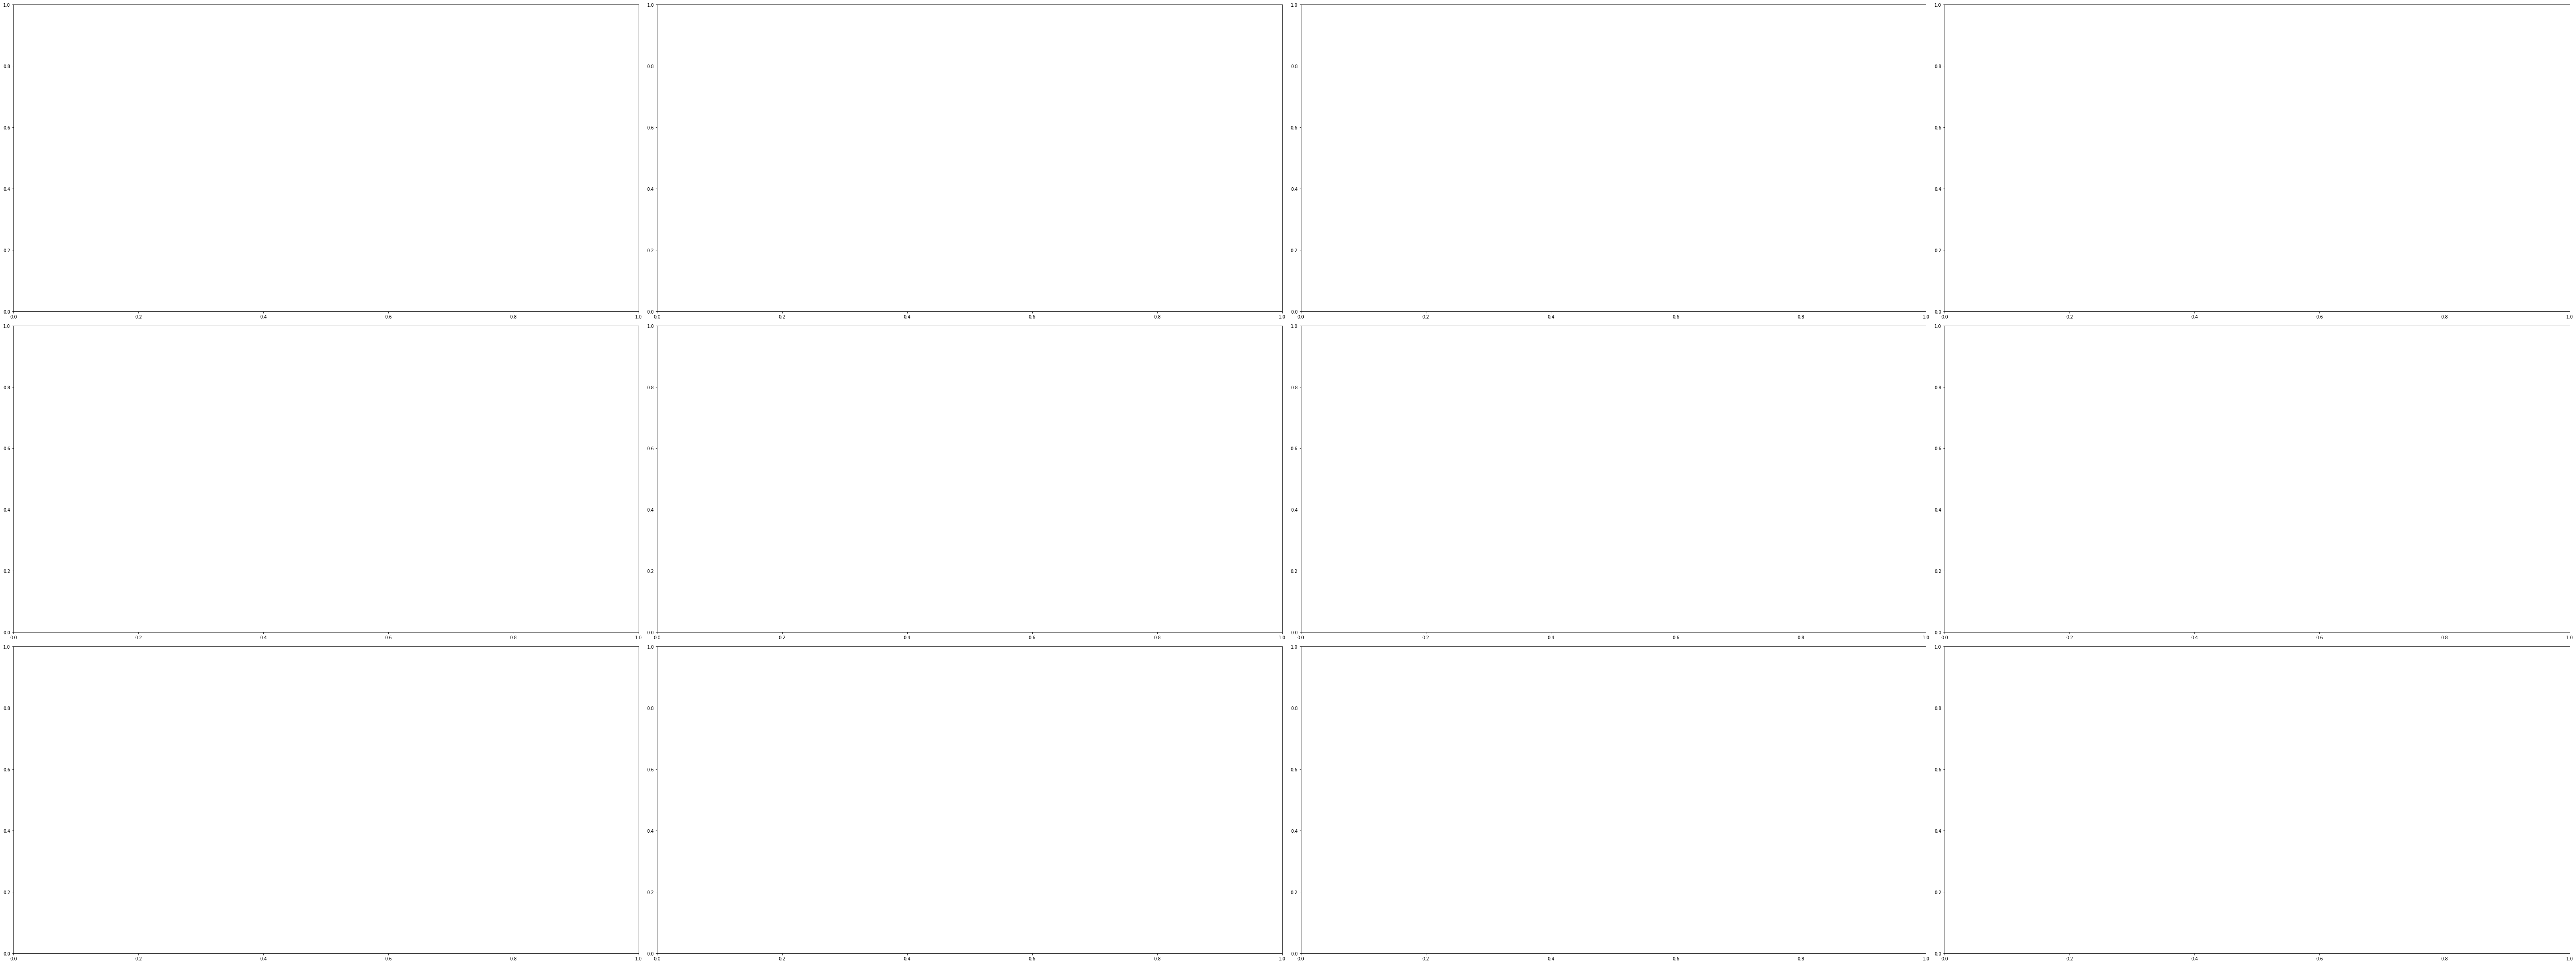

In [48]:
# Visualizing the first 12 images.
OUTPUT_PATH = 'ouput/images_annotated' # relative path from $USER_EXPERIMENT_DIR.
COLS = 4 # number of columns in the visualizer grid.
IMAGES = 12 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)

In [91]:
!ls data_train/train

images	labels


## 9. Deploy! <a class="anchor" id="head-9"></a>

In [49]:
!mkdir -p $USER_EXPERIMENT_DIR/experiment_dir_final
# Removing a pre-existing copy of the etlt if there has been any.
import os
output_file=os.path.join(os.environ['USER_EXPERIMENT_DIR'],
                         "experiment_dir_final/resnet18_detector_thermal.etlt")
if os.path.exists(output_file):
    os.system("rm {}".format(output_file))
!tlt-export detectnet_v2 \
            -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/resnet18_detector_pruned.tlt \
            -o $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector_thermal.etlt \
            -k $KEY

Using TensorFlow backend.
2020-10-08 06:40:47.671198: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-10-08 06:40:57.968325: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-10-08 06:40:57.968508: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-08 06:40:57.969044: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:01:00.0
2020-10-08 06:40:57.969076: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-10-08 06:40:57.969132: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully ope

2020-10-08 06:41:04.371413: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-08 06:41:04.371739: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:01:00.0
2020-10-08 06:41:04.371766: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-10-08 06:41:04.371808: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-10-08 06:41:04.371842: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2020-10-08 06:41:04.371871: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library li

In [31]:
!mkdir -p $USER_EXPERIMENT_DIR/experiment_dir_final_unpruned
# Removing a pre-existing copy of the etlt if there has been any.
import os
output_file=os.path.join(os.environ['USER_EXPERIMENT_DIR'],
                         "experiment_dir_final/resnet18_detector_unpruned.etlt")
if os.path.exists(output_file):
    os.system("rm {}".format(output_file))
!tlt-export detectnet_v2 \
            -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/model.tlt \
            -o $USER_EXPERIMENT_DIR/experiment_dir_final_unpruned/resnet18_detector_unpruned.etlt \
            -k $KEY

Using TensorFlow backend.
2020-10-07 12:47:12.796935: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-10-07 12:47:52.100227: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-10-07 12:47:52.164559: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-07 12:47:52.164886: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:01:00.0
2020-10-07 12:47:52.164913: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-10-07 12:47:52.164968: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully ope

2020-10-07 12:48:25.662067: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-07 12:48:25.662366: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:01:00.0
2020-10-07 12:48:25.662397: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-10-07 12:48:25.662430: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-10-07 12:48:25.662455: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2020-10-07 12:48:25.662472: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library li

In [50]:
print('Exported model:')
print('------------')
!ls -lh $USER_EXPERIMENT_DIR/experiment_dir_final_unpruned

Exported model:
------------
total 1.1G
-rw-r--r-- 1 root root 4.1K Oct  7 12:56 calibration.bin
-rw-r--r-- 1 root root 1.1G Oct  7 12:52 calibration.tensor
-rw-r--r-- 1 root root  23M Oct  7 12:57 resnet18_detector.trt.int8
-rw-r--r-- 1 root root  43M Oct  7 12:56 resnet18_detector_unpruned.etlt


### A. Int8 Optimization <a class="anchor" id="head-9-1"></a>
DetectNet_v2 model supports int8 inference mode in TRT. In order to use int8 mode, we must calibrate the model to run 8-bit inferences. This involves 2 steps

* Generate calibration tensorfile from the training data using tlt-int8-tensorfile
* Use tlt-export to generate int8 calibration table.

*Note: For this example, we generate a calibration tensorfile containing 10 batches of training data.
Ideally, it is best to use atleast 10-20% of the training data to calibrate the model. The more data provided during calibration, the closer int8 inferences are to fp32 inferences.*

In [51]:
!tlt-int8-tensorfile detectnet_v2 -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti.txt \
                                  -m 40 \
                                  -o $USER_EXPERIMENT_DIR/experiment_dir_final_unpruned/calibration.tensor

Using TensorFlow backend.
2020-10-08 07:12:24.999948: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-10-08 07:12:27,016 [INFO] iva.detectnet_v2.spec_handler.spec_loader: Merging specification from /workspace/tlt_specs//detectnet_v2_retrain_resnet18_kitti.txt
2020-10-08 07:12:27,300 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: Serial augmentation enabled = False
2020-10-08 07:12:27,301 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: Pseudo sharding enabled = False
2020-10-08 07:12:27,301 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: Max Image Dimensions (all sources): (0, 0)
2020-10-08 07:12:27,301 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: number of cpus: 16, io threads: 32, compute threads: 16, buffered batches: 4
2020-10-08 07:12:27,301 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: total dataset siz

In [52]:
!rm -rf $USER_EXPERIMENT_DIR/experiment_dir_final_unpruned/resnet18_detector_unpruned.etlt
!tlt-export detectnet_v2 \
            -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/resnet18_detector.tlt \
            -o $USER_EXPERIMENT_DIR/experiment_dir_final_unpruned/resnet18_detector_unpruned.etlt \
            -k $KEY  \
            --cal_data_file $USER_EXPERIMENT_DIR/experiment_dir_final_unpruned/calibration.tensor \
            --data_type int8 \
            --batches 20 \
            --batch_size 4 \
            --max_batch_size 4\
            --engine_file $USER_EXPERIMENT_DIR/experiment_dir_final_unpruned/resnet18_detector.trt.int8 \
            --cal_cache_file $USER_EXPERIMENT_DIR/experiment_dir_final_unpruned/calibration.bin \
            --verbose

Using TensorFlow backend.
2020-10-08 07:13:20.590733: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-10-08 07:13:22.782083: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-10-08 07:13:22.782232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-08 07:13:22.782540: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:01:00.0
2020-10-08 07:13:22.782560: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-10-08 07:13:22.782597: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully ope

2020-10-08 07:13:27,970 [DEBUG] modulus.export._uff: Unpatching keras BatchNormalization layer...
2020-10-08 07:13:27,970 [DEBUG] modulus.export._uff: Unpatching keras Dropout layer...
2020-10-08 07:13:29.501970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-08 07:13:29.502289: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:01:00.0
2020-10-08 07:13:29.502315: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-10-08 07:13:29.502356: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-10-08 07:13:29.502403: I tensorflow/stream_executor/platform/default/dso_loader.cc:44

### B. Generate TensorRT engine <a class="anchor" id="head-9-2"></a>
Verify engine generation using the `tlt-converter` utility included with the docker.

The `tlt-converter` produces optimized tensorrt engines for the platform that it resides on. Therefore, to get maximum performance, please instantiate this docker and execute the `tlt-converter` command, with the exported `.etlt` file and calibration cache (for int8 mode) on your target device. The converter utility included in this docker only works for x86 devices, with discrete NVIDIA GPU's. 

For the jetson devices, please download the converter for jetson from the dev zone link [here](https://developer.nvidia.com/tlt-converter). 

If you choose to integrate your model into deepstream directly, you may do so by simply copying the exported `.etlt` file along with the calibration cache to the target device and updating the spec file that configures the `gst-nvinfer` element to point to this newly exported model. Usually this file is called `config_infer_primary.txt` for detection models and `config_infer_secondary_*.txt` for classification models.

In [53]:
!ls

LICENSE.md	  cmd		 detectnet_v2		    requirements.txt
README.md	  data		 ds_configs		    tlt-converter
Readme.md	  data2kitti.py  face-mask-detection.ipynb  tlt_specs
badimgs.txt	  data_train	 images
check_dataset.py  data_utils	 ouput


In [55]:
!./tlt-converter

./tlt-converter: 17: ./tlt-converter: Syntax error: word unexpected (expecting ")")


In [56]:
!./tlt-converter $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.etlt \
               -k $KEY \
               -c $USER_EXPERIMENT_DIR/experiment_dir_final/calibration.bin \
               -o output_cov/Sigmoid,output_bbox/BiasAdd \
               -d 3,544,960 \
               -i nchw \
               -m 64 \
               -t int8 \
               -e $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.trt \
               -b 4

./tlt-converter: 17: ./tlt-converter: Syntax error: word unexpected (expecting ")")


## 10. Verify Deployed Model <a class="anchor" id="head-10"></a>
Verify the exported model by visualizing inferences on TensorRT.
In addition to running inference on a `.tlt` model in [step 8](#head-8), the `tlt-infer` tool is also capable of consuming the converted `TensorRT engine` from [step 9.B](#head-9-2).

*If after int-8 calibration the accuracy of the int-8 inferences seem to degrade, it could be because the there wasn't enough data in the calibration tensorfile used to calibrate thee model or, the training data is not entirely representative of your test images, and the calibration maybe incorrect. Therefore, you may either regenerate the calibration tensorfile with more batches of the training data, and recalibrate the model, or calibrate the model on a few images from the test set. This may be done using `--cal_image_dir` flag in the `tlt-export` tool. For more information, please follow the instructions in the USER GUIDE.

### A. Inference using TensorRT engine <a class="anchor" id="head-10-1"></a>

In [ ]:
!tlt-infer detectnet_v2 -e $SPECS_DIR/detectnet_v2_inference_kitti_etlt.txt \
                        -o $USER_EXPERIMENT_DIR/etlt_infer_testing \
                        -i $DATA_DOWNLOAD_DIR/testing/image_2 \
                        -k $KEY

In [ ]:
# visualize the first 12 inferenced images.
OUTPUT_PATH = 'etlt_infer_testing/images_annotated' # relative path from $USER_EXPERIMENT_DIR.
COLS = 4 # number of columns in the visualizer grid.
IMAGES = 12 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)